In [1]:
#! pip install torchtext==0.6.0

In [2]:
CUDA_LAUNCH_BLOCKING="1"

# Data processing

'''
Program to read the input data and process it for the transformer model
- Read the file and split into english and corresponding python code
- format the python code into one line
    - factor new line
    - factor tabs

Also build a formatter that converts the single line python code
back to proper syntax for python. This will used for visualization
and verifing the output. This will be used to evaluate the model.


Challenges in the input data

    - Messy start various options to segment the input data 
        #write ; #1 ; #  write
    - clean input file
        - removed # comments len < 10 & 20 after checking 
        - updated few manually
        - remove comments in the code ???
        # dd - remove pattern

Segment the input file
    - identify marker - messy data
    - extract segment
    - extract english sentence within segment
    - extract python code within python
    - format python code to one line




'''

Notes
Done
- changed max length
- Look at data closely

TO DO

- more data
- loss function
- remove #
- remove eos
- doc - add source file
- doc - sample out file
- first line indentation
- = = gap
- loop
- - Python embedding
- not learning space after keyword
- out of bounds while testing
- function name unk

Training Approach

- the PPL and loss kept decreasing while trainings so increased epochs to 30


![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving clean_data.txt to clean_data.txt


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
#from torchtext.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator,TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

from spacy.tokenizer import Tokenizer
import numpy as np
import pandas as pd

import random
import math
import time
import os
import re
import keyword


In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
!python -m spacy download en


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [7]:
#out dataframe
out_df = pd.DataFrame(columns = ['src', 'python'])

input_file = 'clean_data.txt'
output_file = os.path.join('analysis_shortv3.txt')
# first print all lines starting with # with count
with open(output_file,'w') as out_file:
    eng_buf = ''
    py_buf = ''
    samples = 0
    with open(input_file) as in_file:
        for idx,line in enumerate(in_file):
            if line.startswith('#') and len(line) > 30:
                samples = samples + 1
                out_df.loc[len(out_df)] = [eng_buf,py_buf]
                py_buf = ''
                eng_buf = line
                #print(line)
                #out_file.write(line)
            else :
                py_buf = py_buf + line
                #out_file.write(line)
            #if samples > 10:
                #break
print(f" Count of # :{idx}")

# Data cleaning

# Replace tabs with 4 spaces and trim leading and trailing spaces

out_df['python']= out_df['python'].str.replace('\t', '    ')
out_df['python']= out_df['python'].str.strip()

# clean spaces 
# 3->4
# 7->8
# 11->12

reg3s_pat = re.compile(r'(:?\n)[\s]{3}([\w])')
reg7s_pat = re.compile(r'(:?\n)[\s]{7}([\w])')
reg11s_pat = re.compile(r'(:?\n)[\s]{11}([\w])')

def regex_clean(val):

    clean_py = reg3s_pat.sub(r'\1    \2', val)
    clean_py = reg7s_pat.sub(r'\1        \2', clean_py)
    clean_py = reg11s_pat.sub(r'\1            \2', clean_py)
    
    return clean_py

out_df['trg'] = out_df['python'].apply(regex_clean)


 Count of # :42424


In [8]:
out_df['len'] = out_df['trg'].str.len()
fout_df = out_df[out_df['len'] < 500][['src','trg']]
print(len(fout_df)/len(out_df))
fout_df.to_csv('p_data.csv')

0.9629629629629629


In [9]:
len(out_df)

4428

In [10]:
spacy_en = spacy.load('en')

In [11]:

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [12]:
# Tokenizer for python

# Get all keywords
kw_dict = {}
for kw in keyword.kwlist:
    kw_dict[kw]= [{"ORTH":kw}]

# learn 4, 8 12 spaces
special_tabs = ['\\n    ','\\n        ','\\n            ']
for tab in special_tabs:
    kw_dict[tab] = [{"ORTH":tab}]
#kw_dict    

special_cases = kw_dict
#prefix_re = re.compile(r'''^[\[\("']''')
#suffix_re = re.compile(r'''[\]\)"']$''')
#infix_re = re.compile(r'''(==|>=|<=|!=|\(|\)|:|"|\[|\]|=|,|')''')
infix_re = re.compile(r'''(==|>=|<=|!=|\(|\)|:|\[|\]|=|,)''')
#infix_re = re.compile(r'''(==|>=|<=|!=|:|=|,)''')


def python_tokenizer(nlp):
    return Tokenizer(nlp.vocab, rules=special_cases,
                                #prefix_search=prefix_re.search,
                                #suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer)
                                #url_match=simple_url_re.match)


py_custom = python_tokenizer(spacy_en)

In [13]:
def tokenize_py(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in py_custom(text)]

In [14]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

fields = {'src' : ('src', SRC),
          'trg' : ('trg', TRG)}

In [15]:
e2p_data  = TabularDataset(
                            path = 'p_data.csv',
                            format = 'csv',
                            fields = fields
                            )

In [16]:
train_data, valid_data, test_data = e2p_data.split([0.7,.2,.1])

In [17]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_within_batch = True,
    sort_key = lambda x: len(x.src))

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [20]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [22]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [24]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [27]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [28]:
len(TRG.vocab)

6844

In [29]:
device

device(type='cuda')

In [30]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,217,276 trainable parameters


In [32]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [33]:
model.apply(initialize_weights);

In [34]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [35]:
#modified the loss function
# Built a custom function
# If keyword or tab :5
# If among top 50 most frequent : 4 ( most common happen to be ones that help wtih syntax)
# Rest had a weight 1

weight_list = []
for idx,word in enumerate(TRG.vocab.itos):


  #default
  weight = 1.0 
  
  # first 50 except
  #0-3  pad, sos, eos, unk
  if 3 < idx <= 50 :
    weight = 2.0 

  # keyword or tab 
  if (keyword.iskeyword(word)) or ('\n' in word) :
    weight = 3.0
  
  weight_list.append(weight)

class_weights = torch.FloatTensor(weight_list).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index = TRG_PAD_IDX)


In [36]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
training_vis = pd.DataFrame(columns=['epoch','train_loss','val_loss'])
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    training_vis.loc[len(training_vis)] = [epoch+1,train_loss,valid_loss]

Epoch: 01 | Time: 0m 6s
	Train Loss: 6.626 | Train PPL: 754.109
	 Val. Loss: 4.879 |  Val. PPL: 131.467
Epoch: 02 | Time: 0m 6s
	Train Loss: 4.394 | Train PPL:  81.000
	 Val. Loss: 3.761 |  Val. PPL:  42.978
Epoch: 03 | Time: 0m 6s
	Train Loss: 3.437 | Train PPL:  31.082
	 Val. Loss: 3.040 |  Val. PPL:  20.899
Epoch: 04 | Time: 0m 6s
	Train Loss: 2.859 | Train PPL:  17.453
	 Val. Loss: 2.732 |  Val. PPL:  15.363
Epoch: 05 | Time: 0m 6s
	Train Loss: 2.550 | Train PPL:  12.812
	 Val. Loss: 2.531 |  Val. PPL:  12.568
Epoch: 06 | Time: 0m 6s
	Train Loss: 2.329 | Train PPL:  10.270
	 Val. Loss: 2.393 |  Val. PPL:  10.946
Epoch: 07 | Time: 0m 6s
	Train Loss: 2.157 | Train PPL:   8.648
	 Val. Loss: 2.294 |  Val. PPL:   9.913
Epoch: 08 | Time: 0m 6s
	Train Loss: 2.010 | Train PPL:   7.464
	 Val. Loss: 2.200 |  Val. PPL:   9.026
Epoch: 09 | Time: 0m 6s
	Train Loss: 1.887 | Train PPL:   6.600
	 Val. Loss: 2.120 |  Val. PPL:   8.330
Epoch: 10 | Time: 0m 7s
	Train Loss: 1.764 | Train PPL:   5.839


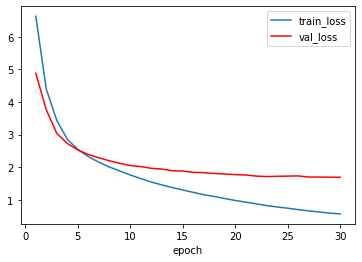

In [40]:
ax = plt.gca()

training_vis.plot(kind='line',x='epoch',y='train_loss',ax=ax)
training_vis.plot(kind='line',x='epoch',y='val_loss', color='red', ax=ax)

plt.show()


In [41]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.607 | Test PPL:   4.987 |


In [42]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 500):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [43]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [44]:
# Function to display generated python code

def display_py(trans_list):
  print('\n')
  final_str = ''
  for string in trans_list:
    if string != '\n':
      final_str = final_str + ' ' + string
    else:
      final_str= final_str + string
  return final_str

In [63]:
example_idx = random.randint(0,len(train_data))

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
print(display_py(trg))

src = ['#', 'write', 'a', 'function', 'to', 'adds', 'two', 'lists', 'element', 'wise', 'only', 'if', 'numbers', 'are', 'even']
trg = ['def', 'adds_listevenelements', '(', 'l1', ':', 'list', ',', 'l2', ':', 'list', ')', ':', '\n    ', 'return', '[i+j', 'for', 'i', ',', 'j', 'in', 'zip', '(', 'l1', ',', 'l2', ')', 'if', 'i*j%2', '==', '0', ']']


 def adds_listevenelements ( l1 : list , l2 : list ) : 
     return [i+j for i , j in zip ( l1 , l2 ) if i*j%2 == 0 ]


In [64]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

predicted trg = ['def', 'add_two_lists', '(', 'list1', ',', 'list2', ')', ':', '\n    ', 'list1', '=', '[5', ',', '3', ',', '4', ',', '6', ',', '7', ']', '\n    ', 'list2', '=', '[5', ',', '1', ']', '\n    ', 'for', 'i', 'in', 'range', '(', 'len', '(', 'list1', ')', ')', ':', '\n        ', 'if', 'list1', '[', 'i', ']', '>', 'list2', ':', '\n            ', 'list2', '=', 'list1', '[', 'j', ']', '\n    ', 'return', 'total', '+', 'list2', '<eos>']


 def add_two_lists ( list1 , list2 ) : 
     list1 = [5 , 3 , 4 , 6 , 7 ] 
     list2 = [5 , 1 ] 
     for i in range ( len ( list1 ) ) : 
         if list1 [ i ] > list2 : 
             list2 = list1 [ j ] 
     return total + list2


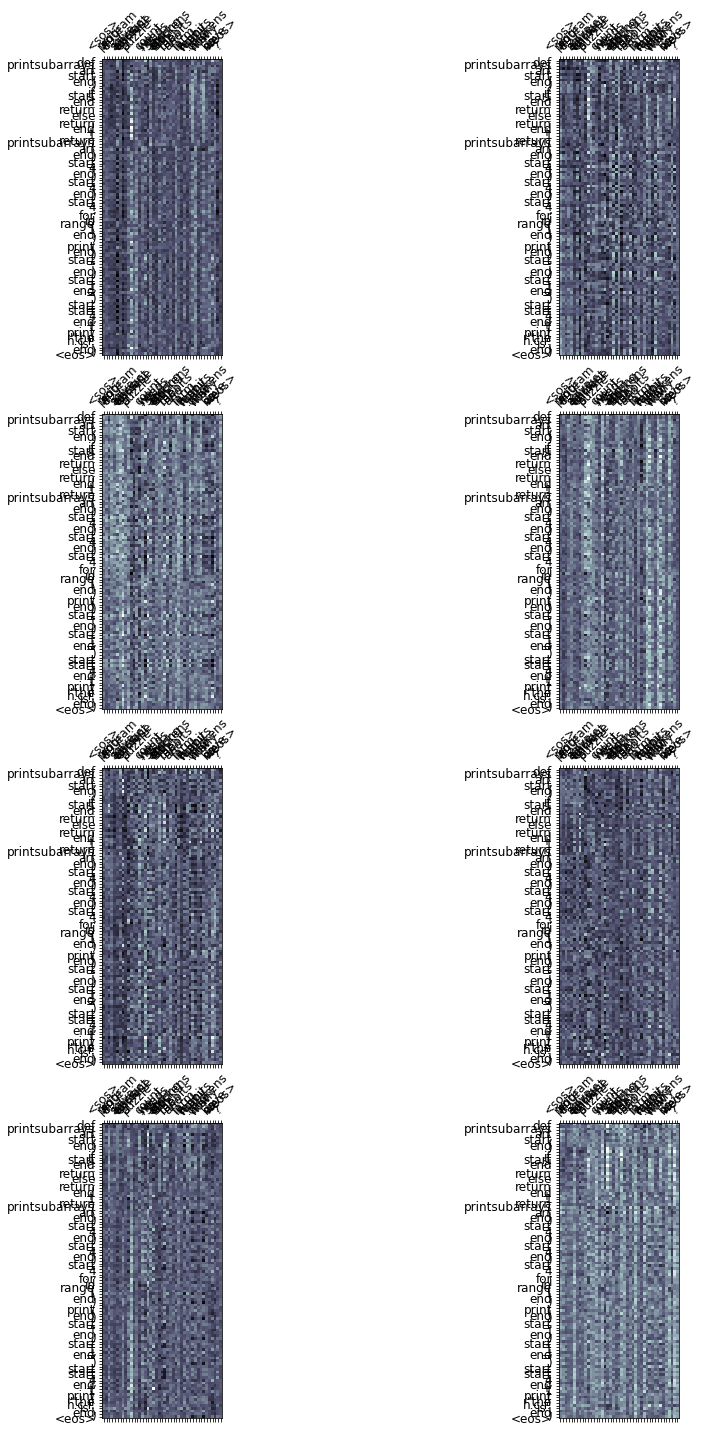

In [47]:
display_attention(src, translation, attention)


In [48]:
example_idx = random.randint(0,len(valid_data))

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
print(display_py(trg))

src = ['#', '---------------------------------------------------------']
trg = ['set1', '=', '{10', ',', '20', ',', '30', ',', '40', ',', '50}', '\n', 'set2', '=', '{30', ',', '40', ',', '50', ',', '60', ',', '70}', '\n', 'print', '(', 'set1.symmetric_difference', '(', 'set2', ')', ')']


 set1 = {10 , 20 , 30 , 40 , 50}
 set2 = {30 , 40 , 50 , 60 , 70}
 print ( set1.symmetric_difference ( set2 ) )


In [49]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

predicted trg = ['set1', '=', '{10', ',', '20', ',', '30', ',', '40', ',', '50}', '\n', 'set2', '=', '{30', ',', '40', ',', '50', ',', '60', ',', '70}', '\n', 'print', '(', 'set1.union', '(', 'set2', ')', ')', '<eos>']


 set1 = {10 , 20 , 30 , 40 , 50}
 set2 = {30 , 40 , 50 , 60 , 70}
 print ( set1.union ( set2 ) )


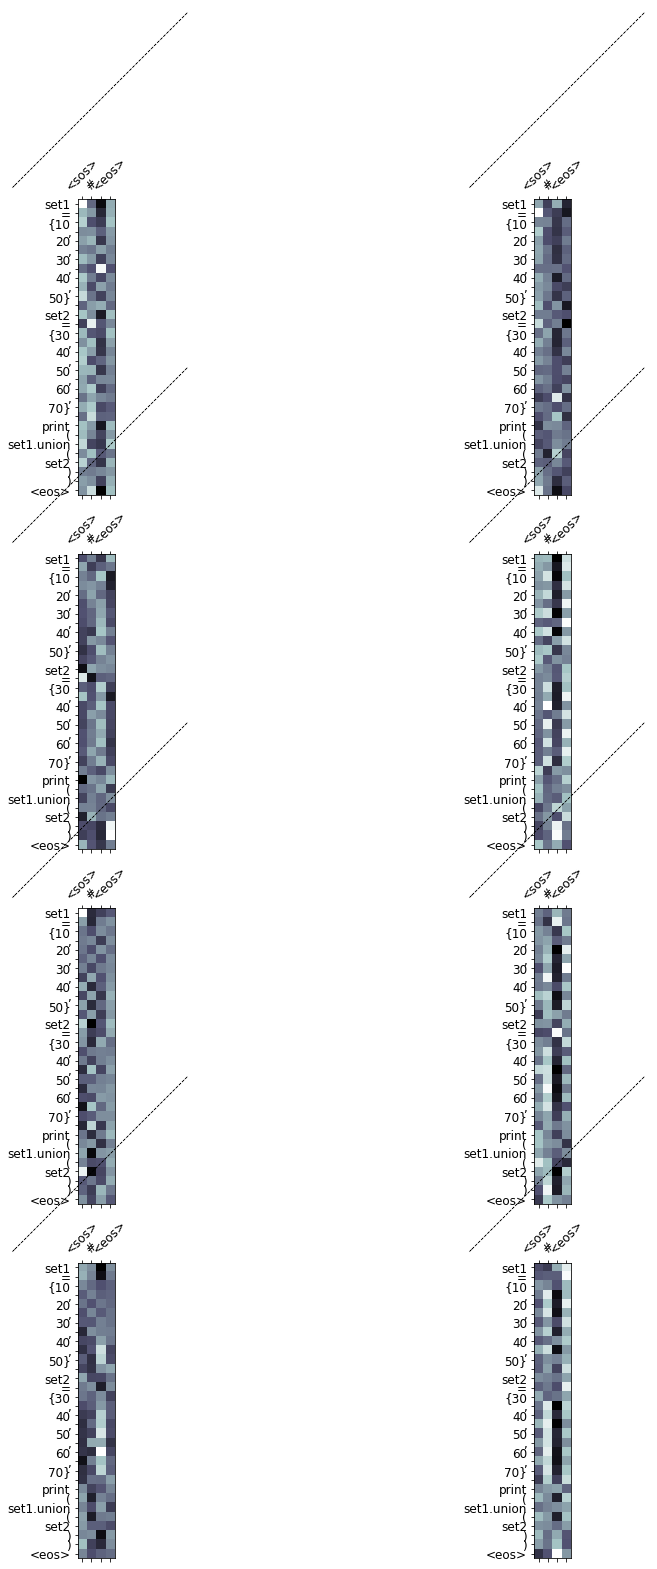

In [50]:
display_attention(src, translation, attention)


In [51]:
example_idx = random.randint(0,len(test_data))

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
print(display_py(trg))

src = ['#', 'write', 'a', 'python', 'function', 'to', 'check', 'if', 'all', 'elements', 'in', 'a', 'list', 'are', 'unique', 'or', 'not']
trg = ['def', 'unique', '(', 'l', ')', ':', '\n    ', 'if', 'len', '(', 'l', ')', '==', 'len', '(', 'set', '(', 'l', ')', ')', ':', '\n        ', 'print', '(', '"all', 'elements', 'are', 'unique"', ')', '\n    ', 'else', ':', '\n        ', 'print', '(', '"list', 'has', 'duplicates"', ')']


 def unique ( l ) : 
     if len ( l ) == len ( set ( l ) ) : 
         print ( "all elements are unique" ) 
     else : 
         print ( "list has duplicates" )


In [52]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

predicted trg = ['def', 'sort_tuple', '(', 'lst', ')', ':', '\n\n    ', 'return', 'len', '(', 'lst', ')', '<eos>']


 def sort_tuple ( lst ) : 

     return len ( lst )


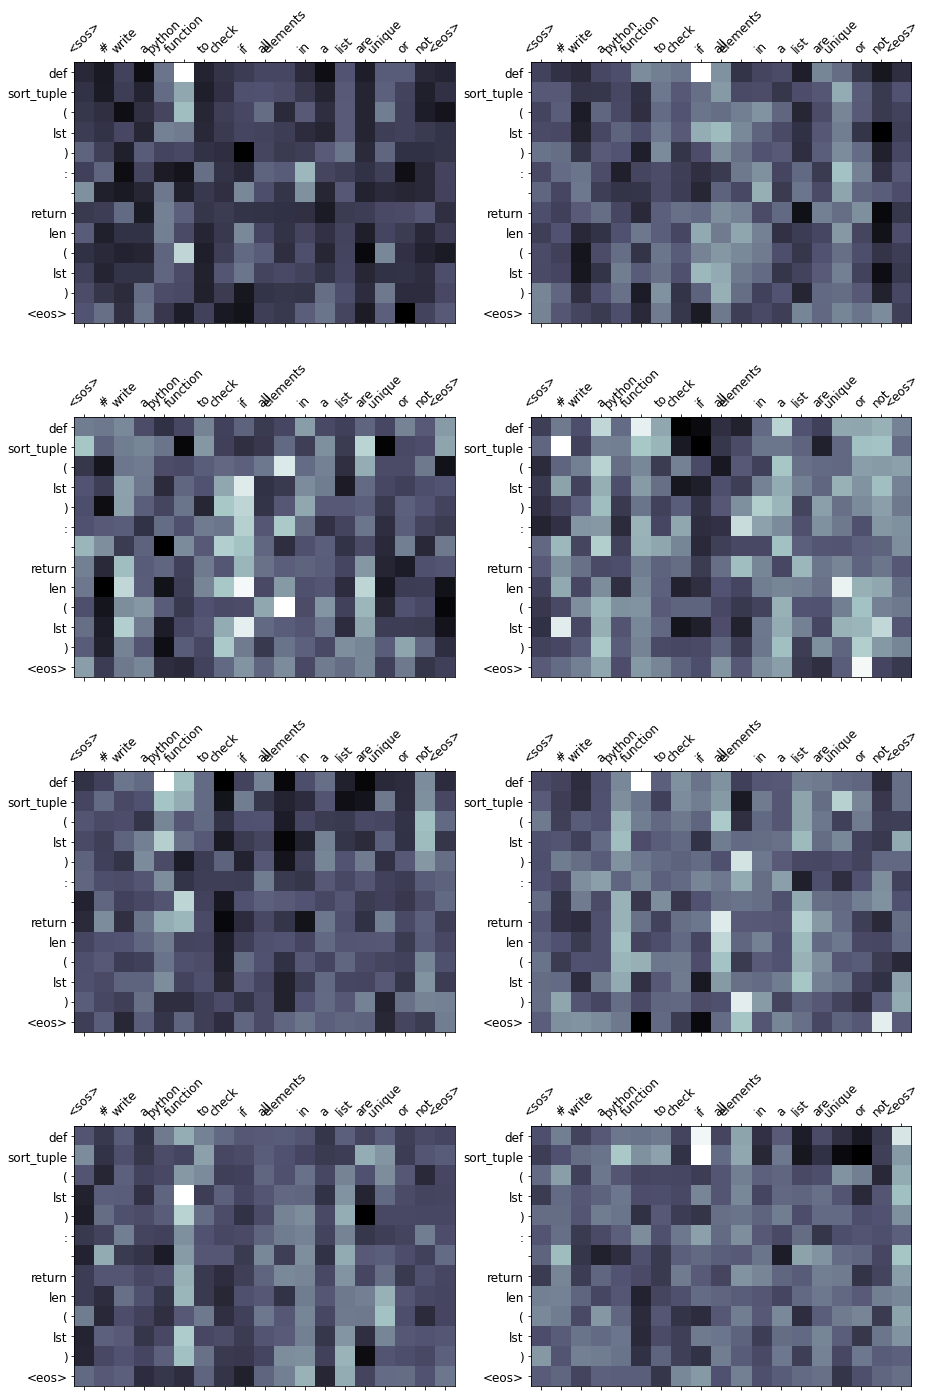

In [53]:
display_attention(src, translation, attention)


In [54]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [55]:
#bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

#print(f'BLEU score = {bleu_score*100:.2f}')

In [56]:
test_sample_idxs = [random.randint(0, len(train_data)) for p in range(0, 3)]
for count,example_idx in enumerate(test_sample_idxs):
  src = vars(train_data.examples[example_idx])['src']
  trg = vars(train_data.examples[example_idx])['trg']
  print(50*"*" + 'Sample    : ' + str(count + 1) + '  ' + 50*"*")
  print('\n')
  print("*******Gold *******")
  eng = ' '.join(src)
  label = display_py(trg)
  print(eng)
  print(label)
  print('\n')
  #print(' '.join(trg))

  print("*******Predicted *******")
  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  print(f'predicted trg = {translation}')
  print(display_py(translation[:-1]))
  print('\n')
  print(100* "*")
  print('\n')

**************************************************Sample    : 1  **************************************************


*******Gold *******


# 97 write a python program to print all permutations of a given string ( including duplicates ) .
 def permute_string ( str ) : 
     if len ( str ) == 0 : 
         return ['' ] 
     prev_list = permute_string ( str [ 1 : len ( str ) ] ) 
     next_list = [ ] 
     for i in range ( 0 , len ( prev_list ) ) : 
         for j in range ( 0 , len ( str ) ) : 
             new_str = prev_list [ i ] [ 0 : j ] +str [ 0 ] +prev_list [ i ] [ j : len ( str ) -1 ] 
             if new_str not in next_list : 
                 next_list.append ( new_str ) 
     return next_lis


*******Predicted *******
predicted trg = ['def', 'check_lower', '(', 'str1', ')', ':', '\n\n    ', 'for', 'char', 'in', 'str1', ':', '\n        ', 'str1', '=', 'char.islower', '(', ')', '\n        ', 'if', 'k', '==', 'true', ':', '\n            ', 'return', 'false', '\n    ', 'if', 'l

In [65]:
src ="Write a python function to add two numbers"

translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(len(translation))
print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

20
predicted trg = ['def', 'lcm', '(', 'x', ',', 'y', ')', ':', '\n    ', 'if', 'x', '>', 'y', ':', '\n      ', 'return', 'x', '+', 'y', '<eos>']


 def lcm ( x , y ) : 
     if x > y : 
       return x + y


In [58]:
TRG.vocab.freqs.most_common(40)

[(')', 11069),
 ('(', 10150),
 (',', 8238),
 (':', 6977),
 ('=', 5861),
 ('\n    ', 3903),
 ('\n', 3814),
 (']', 3344),
 ('[', 2410),
 ('print', 2389),
 ('\n        ', 1797),
 ('in', 1731),
 ('return', 1555),
 ('def', 1530),
 ('for', 1498),
 ('0', 1417),
 ('i', 1365),
 ('1', 1295),
 ('if', 1230),
 ('\n\n', 1158),
 ('+', 1152),
 ('x', 1029),
 ('"', 959),
 ('a', 946),
 ('n', 881),
 ('2', 777),
 ('==', 713),
 ('range', 591),
 ('\n            ', 579),
 ('list', 522),
 ('else', 516),
 ('len', 491),
 ('3', 483),
 ('is', 467),
 ('num', 462),
 ('import', 461),
 ('str', 460),
 ('res', 458),
 ('5', 414),
 ('b', 407)]

In [59]:
TRG.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f1f31b8dbd0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             ')': 4,
             '(': 5,
             ',': 6,
             ':': 7,
             '=': 8,
             '\n    ': 9,
             '\n': 10,
             ']': 11,
             '[': 12,
             'print': 13,
             '\n        ': 14,
             'in': 15,
             'return': 16,
             'def': 17,
             'for': 18,
             '0': 19,
             'i': 20,
             '1': 21,
             'if': 22,
             '\n\n': 23,
             '+': 24,
             'x': 25,
             '"': 26,
             'a': 27,
             'n': 28,
             '2': 29,
             '==': 30,
             'range': 31,
             '\n            ': 32,
             'list': 33,
             'else': 34,
             'len': 35,
             '3': 36,
             'is

In [60]:
TRG.vocab.stoi[TRG.pad_token]

1

In [61]:

keyword.iskeyword('False')

True

In [62]:
type(TRG.vocab.itos)
sample = ['\n        ','senthil']